In [1]:
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

In [2]:
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models' 
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5') 

model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5' 

urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x791c6782a670>)

In [3]:
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]

In [4]:
img_dir = os.getenv('HOME')+'/aiffel/human_segmentation/images'  
images_list = dict()

for file in os.listdir(img_dir):
    path = os.path.join(img_dir, file)

    if file != ".ipynb_checkpoints":
        seg_value, output = model.segmentAsPascalvoc(path)
        images_list.update({file: [cv2.imread(path), seg_value, output]})

image: yhs1.jpg, classes: background chair person sofa  class_ids: [ 0  9 15 18]


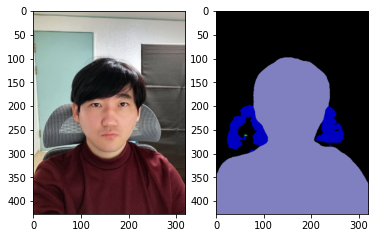

image: yhs3.jpg, classes: background person  class_ids: [ 0 15]


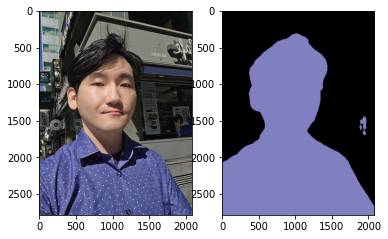

image: dog2.jpg, classes: background dog  class_ids: [ 0 12]


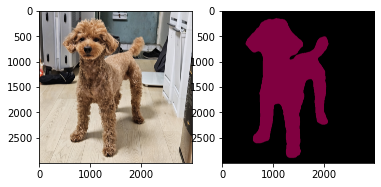

image: yhs2.jpg, classes: background dog person  class_ids: [ 0 12 15]


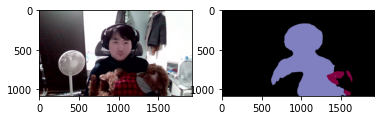

image: dog1.jpg, classes: background dog  class_ids: [ 0 12]


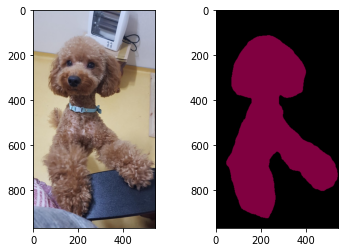

image: my_image.png, classes: background chair person  class_ids: [ 0  9 15]


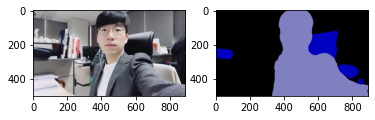

In [15]:
def get_class_name(class_ids):
    class_names = ""
    for class_id in class_ids:
        class_names += f'{LABEL_NAMES[class_id]} '
        
    return class_names

def color_bgr2rgb(colormap):
    rgb = [colormap[2], colormap[1], colormap[0]]
    
    return rgb

for name, list in images_list.items():
    class_ids = list[1]['class_ids']
    print(f'image: {name}, classes: {get_class_name(class_ids)} class_ids: {class_ids}')
    
    plt.subplot(121)
    plt.imshow(cv2.cvtColor(list[0], cv2.COLOR_BGR2RGB))
    plt.subplot(122)
    plt.imshow(list[2])
    plt.show()

In [6]:
#컬러맵 만들기 
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20] #생성한 20개의 컬러맵 출력

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

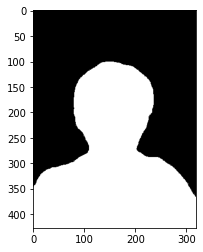

In [7]:
def get_segmentation_masks(images_data):
    masks = dict()
    class_ids = images_data[1]['class_ids']
    output = images_data[2]
    
    for class_id in class_ids:
        cmap = color_bgr2rgb(colormap[class_id])
        masks.update({class_id: np.all(output==cmap, axis=-1)})
    
    return masks

masks = get_segmentation_masks(images_list['yhs1.jpg'])

plt.imshow(masks[15], cmap='gray')
plt.show()

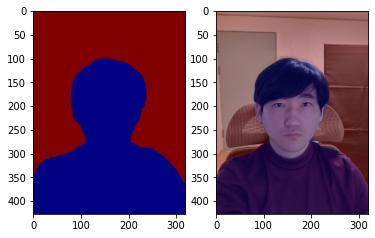

In [8]:
def masking_image(image_data, masking_key):
    mask = get_segmentation_masks(image_data)[masking_key]
    mask = mask.astype(np.uint8) * 255
    mask = cv2.applyColorMap(mask, cv2.COLORMAP_JET)
   
    image = cv2.cvtColor(image_data[0], cv2.COLOR_BGR2RGB)
    image = cv2.addWeighted(image, 0.6, mask, 0.4, 0.0)
    
    plt.subplot(121)
    plt.imshow(mask, cmap="gray")
    plt.subplot(122)
    plt.imshow(image)
    plt.show()

    
masking_image(images_list['yhs1.jpg'], 15)

In [9]:
def get_blurred_background(image_data, masking_key, blur_size=(10,10)):
    blur = cv2.blur(image_data[0], blur_size)
    
    mask = get_segmentation_masks(image_data)[masking_key]
    mask = mask.astype(np.uint8) * 255
    mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
    mask = cv2.bitwise_not(mask)

    image = cv2.bitwise_and(blur, mask)

    return image, mask

get_blurred_background(images_list['yhs1.jpg'], 15)

(array([[[170, 187, 193],
         [170, 187, 193],
         [170, 187, 192],
         ...,
         [172, 180, 186],
         [172, 180, 186],
         [172, 180, 186]],
 
        [[170, 187, 193],
         [170, 187, 193],
         [170, 187, 192],
         ...,
         [172, 180, 186],
         [172, 180, 186],
         [172, 180, 186]],
 
        [[169, 186, 192],
         [169, 186, 192],
         [169, 186, 192],
         ...,
         [172, 180, 185],
         [172, 180, 185],
         [172, 180, 185]],
 
        ...,
 
        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],
 
        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],
 
        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
  

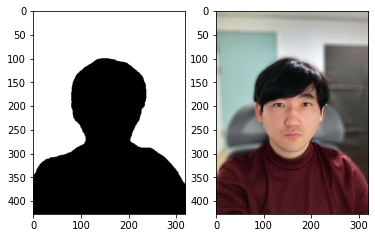

In [12]:
def concat_blurred_background(image_data, masking_key, blur_size=(10,10)):
    image = image_data[0]
    image_bg, mask = get_blurred_background(image_data, masking_key, blur_size)
    
    image_concat = np.where(mask!=255, image, image_bg)
    
    plt.subplot(121)
    plt.imshow(mask)
    plt.subplot(122)
    plt.imshow(cv2.cvtColor(image_concat, cv2.COLOR_BGR2RGB))
    plt.show()

concat_blurred_background(images_list['yhs1.jpg'], 15)

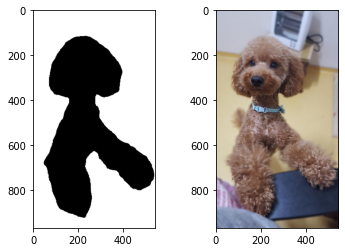

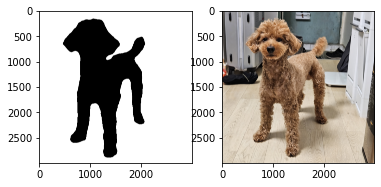

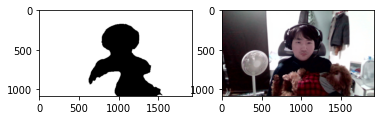

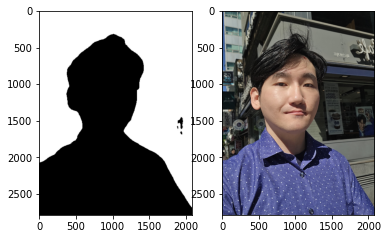

In [14]:
concat_blurred_background(images_list['dog1.jpg'], 12)
concat_blurred_background(images_list['dog2.jpg'], 12)
concat_blurred_background(images_list['yhs2.jpg'], 15)
concat_blurred_background(images_list['yhs3.jpg'], 15)